# How Much Did It Rain? II

- Université Pierre et Marie Curie (UPMC)
- Master Données Apprentissage et Connaissance (DAC)
- Professeur Ludovic Denoyer
- Etudiants Rémi Cadène et Michael Chen

Dans le cadre de la compétition Kaggle : 
https://www.kaggle.com/c/how-much-did-it-rain-ii


Car cancellation guide:
https://github.com/numb3r33/Kaggle-Competitions/blob/master/cars-cancellation/cars_cancellation.ipynb

#Sommaire

1. [Introduction](#Introduction)
2. [Découverte des données](#Découverte-des-données)

#Introduction

En pluviométrie, pour mesurer les hauteurs des précipitations on utilise des jauges qui receuillent la pluie. On est alors capable de déterminer la quantité d'eau tombée durant un intervalle de temps donné, ici une heure.
Cependant, les jauges ne peuvent pas couvrir l'ensemble des lieux que l'on souhaite observer. On utilise alors des radars et on estime la hauteur des précipitations à partir de leurs relevés.
Cependant, ces estimations correspondent mal aux mesures effectués sur les jauges.
L'objectif de ce challenge est de fournir un meilleur estimateur basée sur les relevés des radars.

Note : Nous testons tojours les fonctions prenant un certain à s'executer sur un subset du trainset. 

#Découverte des données

##### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sb
%matplotlib inline  

from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import mean_absolute_error

###### Chargement des données

Les données sont des séquences de relevés de capteurs sur une durée d'une heure à des temps variables.
A chaque séquence est associée un identifiant et la distance du capteur à une jauge dont il faut prédire les mesures à la fin de l'heure.
Un élément de la séquence contient les différentes mesures effectués par le radar à un instant donné.

In [2]:
%%time
dfTrain = pd.read_csv('./data/train.csv')
dfTrain['Id_index'] = dfTrain['Id']
dfTrain = dfTrain.set_index('Id_index')

CPU times: user 41.8 s, sys: 15.6 s, total: 57.5 s
Wall time: 1min 3s


##### Premier aperçu

On commence par regarder succintement les données. On cherche à répondre à des questions d'ordre général sur les données:
- nombre de séquences ?
- nombre de relevés ?
- nombre de dimensions ?
- nombre de dimensions catégorielles ?
- nombre de données manquantes ?

> Il y a 13765201 entrées de 24 dimensions (23 si on exclu la quantité a prédire), toutes numériques.
On voit aussi en extrayant la tête et la queue de la table qu'il y a un certain nombre de données manquantes et qu'il y a 1180945 séquences.

In [118]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13765201 entries, 1 to 1180945
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.6 GB


In [119]:
dfTrain.head(10)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
1,1,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,25,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,35,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,45,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,55,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,2,1,2,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
2,2,6,2,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016
2,2,11,2,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016


In [120]:
dfTrain.tail(10)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
1180945,1180945,14,9,33.5,NaN,32.5,46.5,35.5,6.5,35.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,19,9,43.5,9.5,39.0,49.5,43.5,15.5,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,24,9,31.5,19.5,31.5,41.0,31.5,20.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,28,9,24.0,25.5,31.0,41.0,24.0,25.5,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,33,9,25.5,22.0,27.0,31.0,29.0,25.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,38,9,33.0,19.5,25.5,36.5,33.0,20.5,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,42,9,33.0,21.0,30.5,37.0,36.5,22.0,33.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.636004
1180945,1180945,47,9,29.5,10.0,26.0,30.5,31.0,16.5,26.0,...,1.051667,1.75,NaN,0.750,3.0000,13.379990,NaN,NaN,13.379990,8.636004
1180945,1180945,52,9,19.0,NaN,15.5,26.5,19.0,NaN,16.5,...,1.051667,NaN,NaN,NaN,2.8125,NaN,NaN,NaN,NaN,8.636004


###### Découverte de la distribution des données

- Quelles sont les distributions des données par dimension ?
- Combien de données manquantes par dimension ?
- En particulier, quelle est la distribution de la colonne Expected à prédire ?

> La ligne count nous permet d'évaluer que pour la plupart des colonnes, environ la moitié des données sont manquantes.
La distribution de la colonne Expected est particulière dans le sens où les 3 premiers quartiles sont très bas (respectivement 0.25, 1.02 et 3.81) alors que la moyenne est à 108.63 et le maximum à 33017.73.
C'est-à-dire que la grande majorité des valeurs sont très petites et les grandes valeurs sont extrêmement grandes.
Ceci explique aussi le choix d'une pénalisation sur la norme L1 plutot que L2 qui risquerait de donner un poids démesuré à ces valeurs extrêmes.

In [121]:
dfTrain.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,13765201.000000,13765201.000000,13765201.000000,6349375.000000,5283988.000000,6356482.000000,7551281.000000,6716343.000000,5755673.000000,6711663.000000,...,5905584.000000,4934916.000000,4133154.000000,4936568.000000,5905584.000000,4182635.000000,3428782.000000,4187281.000000,5052776.000000,13765201.000000
mean,592336.986614,29.523733,11.067943,22.926658,19.952271,22.610287,25.898461,24.711081,22.158238,24.420753,...,1.015272,0.536709,-0.719008,0.337622,2.072870,0.035452,-3.482325,-0.473655,4.079836,108.626306
std,340856.086254,17.308131,4.206618,10.355157,9.208166,10.053000,11.109579,10.689622,9.702705,10.424526,...,0.048616,1.510399,1.006068,0.938644,1.670194,3.869725,2.792120,2.263046,4.147337,548.605805
min,1.000000,0.000000,0.000000,-31.000000,-32.000000,-32.000000,-28.500000,-32.000000,-31.000000,-27.500000,...,0.208333,-7.875000,-7.875000,-7.875000,-7.875000,-96.040000,-80.790000,-78.770004,-100.200005,0.010000
25%,296897.000000,15.000000,9.000000,16.000000,14.000000,16.000000,18.000000,17.500000,16.000000,17.500000,...,0.998333,-0.187500,-1.125000,-0.062500,1.062500,-1.410004,-4.580002,-0.710007,2.069992,0.254000
50%,592199.000000,30.000000,11.000000,22.500000,20.000000,22.500000,25.500000,24.000000,22.000000,24.000000,...,1.011667,0.375000,-0.625000,0.250000,1.687500,0.000000,-2.820007,0.000000,3.519989,1.016000
75%,889582.000000,44.000000,14.000000,29.500000,26.000000,29.000000,33.500000,31.500000,28.500000,31.500000,...,1.051667,1.062500,-0.187500,0.687500,2.625000,1.750000,-1.760010,0.349991,5.639999,3.810002
max,1180945.000000,59.000000,21.000000,71.000000,62.500000,69.000000,72.500000,92.500000,66.000000,71.000000,...,1.051667,7.937500,7.937500,7.937500,7.937500,179.750000,3.519989,12.800003,144.600000,33017.730000


- Même distribution pour les données de test ?
> à peu de chose prêt oui, on peut supposer que les données sont i.i.d.

In [8]:
dfTest = pd.read_csv('./data/test.csv')
dfTest = dfTest.set_index('Id')
dfTest.describe()

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
count,8022756.000000,8022756.000000,3663128.000000,3067995.000000,3668089.000000,4340793.000000,3839046.000000,3294829.000000,3836932.000000,4473633.000000,...,2950786.000000,3517705.000000,2948456.000000,2476929.000000,2950786.000000,3517705.000000,2520616.000000,2066571.000000,2524497.000000,3037988.000000
mean,29.502363,11.033185,22.410680,19.540045,22.108217,25.314470,24.110474,21.647148,23.824119,26.726395,...,0.977385,1.015914,0.512816,-0.719075,0.315634,2.033802,0.037542,-3.545983,-0.470521,4.157142
std,17.314337,4.191674,9.978445,8.924519,9.692145,10.666716,10.344510,9.436371,10.086178,11.097858,...,0.068996,0.047160,1.442870,0.946104,0.861814,1.581502,3.916815,2.833394,2.264604,4.170181
min,0.000000,0.000000,-27.000000,-30.500000,-27.000000,-24.500000,-25.000000,-28.500000,-31.000000,-25.500000,...,0.208333,0.208333,-7.875000,-7.875000,-7.875000,-7.875000,-96.840004,-104.700005,-83.990005,-89.690000
25%,15.000000,9.000000,16.000000,14.000000,16.000000,18.000000,17.000000,15.500000,17.000000,19.000000,...,0.978333,0.998333,-0.187500,-1.125000,0.000000,1.062500,-1.410004,-4.580002,-0.710007,2.069992
50%,29.000000,11.000000,22.000000,19.500000,22.000000,25.000000,23.500000,21.500000,23.500000,26.500000,...,0.991667,1.011667,0.375000,-0.625000,0.250000,1.687500,0.000000,-2.820007,0.000000,3.519989
75%,44.000000,14.000000,29.000000,25.500000,28.500000,32.500000,31.000000,28.000000,30.500000,34.000000,...,0.998333,1.051667,1.062500,-0.187500,0.625000,2.562500,1.759994,-1.760010,0.349991,5.869995
max,59.000000,21.000000,71.500000,67.500000,69.000000,77.000000,88.000000,69.000000,73.500000,94.500000,...,1.051667,1.051667,7.937500,7.937500,7.937500,7.937500,164.739990,3.519989,12.690002,138.060000


- Combien de séquences ?
- Quelle est la taille des séquences ?
- Distribution de la longueur des séquences (quantile) ?
> Environ 14.000.000 de relevés pour 1.200.000 séquences, soit une moyenne de 11.7 relevés par séquence. 

In [4]:
dfGrouped = dfTrain.groupby(dfTrain.index)
dfLength = dfGrouped.size()

In [7]:
dfLength.describe()

count    1180945.000000
mean          11.656090
std            3.254159
min            1.000000
25%           10.000000
50%           12.000000
75%           14.000000
max           19.000000
dtype: float64

In [11]:
for pc in [.1,.3,.5,.7,.9]:
    print "quantile "+str(pc)+":", dfLength.quantile(pc)

quantile 0.1: 6.0
quantile 0.3: 10.0
quantile 0.5: 12.0
quantile 0.7: 13.0
quantile 0.9: 16.0


- Les relevés sont créés de façon periodique ?
> Non, il faudra donc trouver des moyens de prendre cette information en compte, via une pondération par les écarts de temps entre deux relevés par exemple.

In [45]:
# Moyenne des différences temporelles de mesure, normalisées par la taille de la séquence
display = False
def myfunc(seq):
    seq = seq.sort_values('minutes_past', ascending=True)
    mn_past = seq['minutes_past'].values
    if display:
        print 'mn_past', mn_past
    dif = (mn_past[1:] - mn_past[:-1])
    if display:
        print dif
    return dif.mean() * .1 / len(mn_past) 

In [46]:
dfGrouped.apply(myfunc).mean()

0.06807704641037976

In [47]:
display = True
dfTrain[:100].groupby(dfTrain[:100].index).apply(myfunc).mean()

mn_past [ 3 16 25 35 45 55]
[13  9 10 10 10]
mn_past [ 3 16 25 35 45 55]
[13  9 10 10 10]
mn_past [ 1  6 11 16 21 26 31 37 42 47 53 58]
[5 5 5 5 5 5 6 5 5 6 5]
mn_past [ 4  9 14 18 23 28 33 38 43 48 53 58]
[5 5 4 5 5 5 5 5 5 5 5]
mn_past [ 0  5  9 14 19 23 28 33 38 42 47 52 56]
[5 4 5 5 4 5 5 5 4 5 5 4]
mn_past [ 0  4  9 13 17 22 26 30 35 39 45 50 54 58]
[4 5 4 4 5 4 4 5 4 6 5 4 4]
mn_past [ 3 16 25 35 45 55]
[13  9 10 10 10]
mn_past [ 3  7 11 15 19 23 27 31 35 39 43 47 51 55 58]
[4 4 4 4 4 4 4 4 4 4 4 4 4 3]
mn_past [ 3  8 13 18 23 29 34 39 44 49 54 59]
[5 5 5 5 6 5 5 5 5 5 5]
mn_past [ 1  6 10 14 19 24 28 33 37 42]
[5 4 4 5 5 4 5 4 5]


0.06807704641037976

##### Découverte des données manquantes

Il y aurait 38% de données manquantes
https://www.kaggle.com/c/how-much-did-it-rain-ii/forums/t/16572/38-missing-data

- Combien y'a-t-il de données manquantes par dimension ?
> Beaucoup

In [51]:
l = float(len(dfTrain["Id"]))
comp = []
for i in dfTrain.columns:
    comp.append([1 - dfTrain[i].isnull().sum() / l , i])
comp.sort(key=lambda x: x[0], reverse=True)

In [50]:
comp

[[1.0, 'Id'],
 [1.0, 'minutes_past'],
 [1.0, 'radardist_km'],
 [1.0, 'Expected'],
 [0.56876779351060691, 'RefComposite_5x5_90th'],
 [0.54857760522349075, 'Ref_5x5_90th'],
 [0.48792189812557041, 'RefComposite'],
 [0.48758191035495957, 'RefComposite_5x5_50th'],
 [0.46177909062134292, 'Ref_5x5_50th'],
 [0.4612627886799473, 'Ref'],
 [0.42902272186217982, 'RhoHV_5x5_90th'],
 [0.42902272186217982, 'Zdr_5x5_90th'],
 [0.41813214351174388, 'RefComposite_5x5_10th'],
 [0.38386566240478437, 'Ref_5x5_10th'],
 [0.36706881359741861, 'Kdp_5x5_90th'],
 [0.35862665572409735, 'RhoHV_5x5_50th'],
 [0.35862665572409735, 'Zdr_5x5_50th'],
 [0.35850664294695012, 'RhoHV'],
 [0.35850664294695012, 'Zdr'],
 [0.30419323335707193, 'Kdp_5x5_50th'],
 [0.30385571558308522, 'Kdp'],
 [0.30026107137847102, 'RhoHV_5x5_10th'],
 [0.30026107137847102, 'Zdr_5x5_10th'],
 [0.2490905871988357, 'Kdp_5x5_10th']]

- Combien y'a-t-il de relevés totalement nulles sauf minutes_past, radardist_km et expected ?
> environ 80% des relevés possèdent au moins une valeur NaN

In [53]:
dfLight = dfTrain.drop(['minutes_past','radardist_km', 'Expected'],axis=1)
nbIds = len(dfLight.index)
nbIdsAllNan = len(dfLight.dropna(how='all').index)
nbIdsAnyNan = len(dfLight.dropna(how='any').index)
print "nombre de séquences avec NaN:", nbIds
print "nombre de séquences sans all NaN:", nbIdsAllNan, (nbIdsAllNan * 1. / nbIds * 100)
print "nombre de séquences sans any NaN:", nbIdsAnyNan, (nbIdsAnyNan * 1. / nbIds * 100)

nombre de séquences avec NaN: 13765201
nombre de séquences sans all NaN: 13765201 100.0
nombre de séquences sans any NaN: 2769088 20.1165823877


L'administrateur du challenge précise que les séquences pour lesquelles toutes les Ref (colonne \#4) sont manquantes ne seront pas prises en compte, alors nous allons les enlever.
https://www.kaggle.com/c/how-much-did-it-rain-ii/forums/t/16622/ignored-ids

- Combien de séquences possèdent des mesures de Ref uniquement NaN ?
> 449389 séquences à enlever, soit 38% du trainset

In [5]:
%%time
def myfunc(seq):
    nb = len(seq['Ref'])
    if seq['Ref'].isnull().sum() == nb:
        return seq['Id'].values[0]
    return -1
    
dfIds2rmv = dfGrouped.apply(myfunc)

CPU times: user 3min 8s, sys: 5.9 s, total: 3min 14s
Wall time: 3min 20s


In [9]:
len2rmv = (dfIds2rmv > -1).sum()
print 'Nombre de séquences à enlever: ', len2rmv, 'sur', len(dfIds2rmv), 'soit ', (len2rmv * 100. / len(dfIds2rmv)), '% du trainset'

Nombre de séquences à enlever:  449389 sur 1180945 soit  38.0533386398 % du trainset


In [10]:
dfTrain.drop(dfIds2rmv.values,axis=0,inplace=True)

In [25]:
#dfTrain.to_csv('./data/train_nnull.csv')
#dfTrain = pd.read_csv('./data/train_nnull.csv')

- Et maintenant ? Combien y'a-t-il de données manquantes par dimension ?
> Encore beaucoup

In [66]:
l = float(len(df["Id"]))
comp = []
for i in df.columns:
    comp.append([1 - df[i].isnull().sum() / l , i])
comp.sort(key=lambda x: x[0], reverse=True)
comp

[[1.0, 'Id'],
 [1.0, 'minutes_past'],
 [1.0, 'radardist_km'],
 [1.0, 'Expected'],
 [0.83874674545980754, 'RefComposite_5x5_90th'],
 [0.81298690710219867, 'Ref_5x5_90th'],
 [0.73376576340425648, 'RefComposite'],
 [0.73326320618138807, 'RefComposite_5x5_50th'],
 [0.6961873922573093, 'Ref_5x5_50th'],
 [0.69579683099644951, 'Ref'],
 [0.62983877074459449, 'RefComposite_5x5_10th'],
 [0.62100906170067949, 'RhoHV_5x5_90th'],
 [0.62100906170067949, 'Zdr_5x5_90th'],
 [0.5790412597726613, 'Ref_5x5_10th'],
 [0.53625069298871308, 'Kdp_5x5_90th'],
 [0.5287214302081602, 'RhoHV_5x5_50th'],
 [0.5287214302081602, 'Zdr_5x5_50th'],
 [0.52724093564188212, 'RhoHV'],
 [0.52724093564188212, 'Zdr'],
 [0.44919027029052871, 'Kdp_5x5_50th'],
 [0.44806943398972243, 'Kdp'],
 [0.44635716695803518, 'RhoHV_5x5_10th'],
 [0.44635716695803518, 'Zdr_5x5_10th'],
 [0.37034357884521207, 'Kdp_5x5_10th']]

- Y'a-t-il des typologies visibles de séquences de NaN ?
> Ci-dessous on peut voir que certaines colonnes sont totalement vides. Nous pensons alors qu'il va nous falloir développer des algorithmes plus ou moins complexes de remplissage des ces valeurs NaN. On imagine enlever certaines mesures ou séquences, ou alors interpoler certaines mesures, ou encore remplire les NaN par la moyenne de la colonne.

In [73]:
df.loc[4]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id_index,,,,,,,,,,,,,,,,,,,,,
4,4,0,9,18.5,16.0,19.0,23.5,24.5,22.0,23.5,...,0.998333,NaN,NaN,NaN,1.4375,NaN,NaN,NaN,NaN,4.064002
4,4,5,9,22.0,14.0,21.0,30.0,25.5,22.5,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,9,9,35.5,24.5,30.5,35.5,35.5,25.5,31.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,14,9,16.5,NaN,19.0,34.5,23.5,16.5,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,19,9,16.0,NaN,11.0,18.0,20.5,13.5,18.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,23,9,NaN,NaN,NaN,26.0,7.5,12.0,18.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,28,9,32.5,10.5,34.5,43.0,42.5,19.5,39.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,33,9,41.5,33.5,39.5,44.5,43.0,36.0,41.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002
4,4,38,9,34.0,33.5,37.5,42.5,37.0,35.5,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.064002


##### Découverte des outliers

- Y'a-t-il des outliers ? A partir de quand, peut on considérer une séquence comme étant un outlier ?
> Deux explications : 
> - Les valeurs de expected au dessus de 1000 mm/h peuvent être des erreurs : https://www.kaggle.com/sudalairajkumar/how-much-did-it-rain-ii/rainfall-test/log
> - Some of the extremely high Expected values may be due to the melting of ice precipitation that has collected in the rain gauge, which would release a flood of water in a relatively short period of time. If the rain gauges are heated, then snow filling the gauge and then melting later should not be as much of an issue, but hail or graupel filling the top of the gauge could cause underestimation initially by blocking rain from entering the gauge, then overestimation due to melting and draining into the gauge. The real trick will be to train an algorithm to recognize these instances.
https://www.kaggle.com/c/how-much-did-it-rain/forums/t/11479/expected/62593
> - https://en.wikipedia.org/wiki/DBZ_(meteorology)

- Combien y'a-t-il d'outliers ? Quantile
> 4864 séquences 

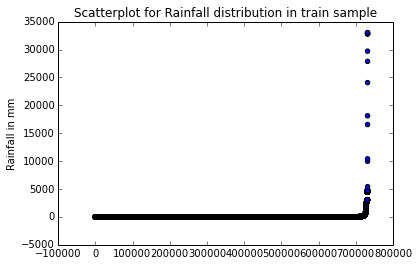

In [12]:
dfGrouped = dfTrain.groupby(dfTrain.index)
dfExpected = dfGrouped['Expected'].aggregate('mean')
exp_rainfall = np.sort(np.array(dfExpected))
plt.figure()
plt.scatter(np.arange(exp_rainfall.shape[0]), exp_rainfall)
plt.title("Scatterplot for Rainfall distribution in train sample")
plt.ylabel("Rainfall in mm")
plt.show()

In [21]:
for pc in [.1,.3,.5,.7,.9,.91,.93,.95,.97,.99, .991, .992, .993, .994, .995, .996, .997, .998, .999]:
    print "quantile "+str(pc)+":", dfExpected.quantile(pc)

quantile 0.1: 0.25400013
quantile 0.3: 0.50800025
quantile 0.5: 1.2700007
quantile 0.7: 2.7940013
quantile 0.9: 9.906006
quantile 0.91: 11.176005
quantile 0.93: 14.000007
quantile 0.95: 19.812012
quantile 0.97: 40.38602
quantile 0.99: 368.3002
quantile 0.991: 474.99924
quantile 0.992: 614.42633
quantile 0.993: 764.5404
quantile 0.994: 1140.4606
quantile 0.995: 1721.4224775
quantile 0.996: 2537.7153
quantile 0.997: 2796.0334
quantile 0.998: 2853.4375
quantile 0.999: 2945.1316


In [23]:
print "Nombre d'expected au dessus de 1000mm/h ? ", exp_rainfall[exp_rainfall >= 1000].shape[0]
print "Pourcentage d'outliers ? ", exp_rainfall[exp_rainfall >= 1000].shape[0] * 1. / exp_rainfall.shape[0] * 100, '%'

Nombre d'expected au dessus de 1000mm/h ?  4864
Pourcentage d'outliers ?  0.664884164712 %


- Doit-on retirer ces valeurs lors de l'apprentissage de notre modèle ?
> Intuitivement non, car elles sont fortement prises en compte par notre critère MAE

- Correspondent-elles à des erreurs de mesures détectables ?
> Deux grandes approches possibles pour http://eprints.whiterose.ac.uk/767/1/hodgevj4.pdf. La première consiste à utiliser un algorithme d'apprentissage non supervisé comme K-Means et voir si un ou plusieurs clusters regroupent une grande partie des outliers. La seconde consiste à entraîner un classifeur binaire à détecter les outliers. Intuitivement, cette deuxième approche parraît plus efficace si le classifieur généralise assez, car nous n'avons que 4864 exemples d'outliers. Il faudra aussi choisir 4864 exemples représentatifs des non outliers. On notera que d'après http://ijcttjournal.org/Volume3/issue-2/IJCTT-V3I2P118.pdf, il est possible de détecter des outliers de façon non supervisés avec des algorithmes comme One-class SVMs ou One-class Kernel Fisher Discriminants.


# Modèles simples

Dans cette section nous allons créer et évaluer trois modèles simples dans le but de créer une baseline privée que nous comparerons avec les performances de nos futurs modèles.
> - Score du modèle Marshall Palmer : 23.43
> - Score du modèle Median Expected : 23.53
> - Score du modèle Mean Expected : 41.04

##### Marshall Palmer

https://en.wikipedia.org/wiki/DBZ_(meteorology)

In [26]:
def marshall_palmer(ref, minutes_past):
    #print "Estimating rainfall from {0} observations".format(len(minutes_past))
    # how long is each observation valid?
    valid_time = np.zeros_like(minutes_past)
    valid_time[0] = minutes_past.iloc[0]
    for n in xrange(1, len(minutes_past)):
        valid_time[n] = minutes_past.iloc[n] - minutes_past.iloc[n-1]
    valid_time[-1] = valid_time[-1] + 60 - np.sum(valid_time)
    valid_time = valid_time / 60.0
    # sum up rainrate * validtime
    sum = 0
    for dbz, hours in zip(ref, valid_time):
        # See: http s://en.wikipedia.org/wiki/DBZ_(meteorology)
        if np.isfinite(dbz):
            mmperhr = pow(pow(10, dbz/10)/200, 0.625)
            sum = sum + mmperhr * hours
    return sum

def process_mp(seq):
    seq = seq.sort_values('minutes_past', ascending=True)
    #seq = seq.sort('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'], seq['minutes_past'])
    return mp

In [27]:
%%time
dfGrouped = dfTrain.groupby(dfTrain.index)
dfExpected = dfGrouped['Expected'].aggregate('mean')
dfMp = pd.DataFrame(index=dfTrain.index.unique())
dfMp['Expected'] = dfGrouped[['minutes_past', 'Ref', 'Expected']].apply(process_mp)

CPU times: user 8min 54s, sys: 4.78 s, total: 8min 59s
Wall time: 9min 8s


In [31]:
mean_absolute_error(dfMp, dfExpected)

23.43039549242723

##### Mean Expected

In [51]:
dfMean = pd.DataFrame(index=dfTrain.index.unique())
array = np.empty(len(dfExpected))
array.fill(dfExpected.mean())
dfMean['Expected'] = array
mean_absolute_error(dfMean, dfExpected)

41.035710453419725

##### Median Expected

In [52]:
dfMedian = pd.DataFrame(index=dfTrain.index.unique())
array = np.empty(len(dfExpected))
array.fill(dfExpected.median())
dfMedian['Expected'] = array
mean_absolute_error(dfMedian, dfExpected)

23.53059069378909

# Extraction de features

## Few features

Nous nous sommes inspirés de la dernière compétion pour l'extraction de features :
https://www.kaggle.com/c/how-much-did-it-rain/forums/t/14242/congratulations

Nous allons extraires des features faciles, puis nous séparerons notre datatrain en deux parties, une qui nous servira à entrainer des modèles de régression, l'autre (de validation) qui nous servira à évaluer nos modèles.

- Quelle première méthode d'extraction de features ?
> Extractions de features simple :
> - marshall palmer
> - aggrégation moyenne sur la séquence

In [11]:
size = len(df)
pc = .0010 # 0.5% -> 2h pour tout process
dfTry = df[:int(size * pc)]
len(dfTry)

9125

In [62]:
f_cols = ['radardist_km', 'Ref', 'Ref_5x5_10th', 'Ref_5x5_50th',
       'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
       'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th', 'marshall_palmer']

In [54]:
dfSmallFeatures = dfGrouped.mean()
dfSmallFeatures['marshall_palmer'] = dfMp

- Est-ce que certaines features sont corrélées deux à deux ? et corrélées avec Expected ?
> Non, ce qui signifie qu'un modèle linéaire aura du mal.

In [55]:
dfSmallFeatures.corr()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected,marshall_palmer
Id,1.000000,0.005332,0.003219,-0.015406,-0.012982,-0.015123,-0.016420,-0.016830,-0.016265,-0.016080,...,0.001619,-0.018125,-0.011180,0.009263,0.003360,-0.015206,-0.009469,0.013785,-0.000252,-0.006003
minutes_past,0.005332,1.000000,-0.013712,0.008189,0.006239,0.007419,0.008529,0.009016,0.007181,0.008272,...,0.000446,0.009359,0.007003,0.002855,-0.001856,0.006353,0.002534,-0.003029,-0.001091,0.010962
radardist_km,0.003219,-0.013712,1.000000,0.069752,0.132316,0.064998,0.019148,-0.046264,-0.016114,-0.051791,...,-0.204493,-0.194019,-0.351809,-0.262297,-0.004878,-0.325868,-0.167557,0.222136,0.030389,-0.096360
Ref,-0.015406,0.008189,0.069752,1.000000,0.926084,0.977188,0.941408,0.958385,0.905778,0.942914,...,-0.121950,0.258910,0.044829,-0.247298,-0.007781,0.055542,0.155408,0.079802,-0.042359,0.616757
Ref_5x5_10th,-0.012982,0.006239,0.132316,0.926084,1.000000,0.941992,0.874808,0.889300,0.941517,0.899110,...,-0.107254,0.269259,0.000976,-0.272781,-0.001668,0.045419,0.151442,0.101225,-0.013257,0.582364
Ref_5x5_50th,-0.015123,0.007419,0.064998,0.977188,0.941992,1.000000,0.945030,0.949768,0.927672,0.962433,...,-0.117468,0.267182,0.045813,-0.255657,-0.007608,0.059386,0.161788,0.083436,-0.029461,0.613124
Ref_5x5_90th,-0.016420,0.008529,0.019148,0.941408,0.874808,0.945030,1.000000,0.940908,0.881186,0.943271,...,-0.111431,0.235223,0.074810,-0.209900,-0.009987,0.054727,0.157469,0.070042,-0.047614,0.615435
RefComposite,-0.016830,0.009016,-0.046264,0.958385,0.889300,0.949768,0.940908,1.000000,0.936063,0.980648,...,-0.100545,0.274127,0.090758,-0.212151,-0.013688,0.093727,0.167555,0.045447,-0.048284,0.619834
RefComposite_5x5_10th,-0.016265,0.007181,-0.016114,0.905778,0.941517,0.927672,0.881186,0.936063,1.000000,0.949928,...,-0.084534,0.290101,0.065161,-0.235308,-0.008703,0.090754,0.165058,0.061011,-0.021823,0.588306
RefComposite_5x5_50th,-0.016080,0.008272,-0.051791,0.942914,0.899110,0.962433,0.943271,0.980648,0.949928,1.000000,...,-0.095621,0.277443,0.091454,-0.216401,-0.013065,0.096867,0.171223,0.047103,-0.036889,0.618934


- Que se passe-t-il si on enlève certains outliers ?
> En décidant d'enlever tous les exemples ayant un Expected supérieur à 69, on remarque que Expected est corrélé avec :
  - marshall_palmer : ~= 0.36
  - Ref_X : ~= 0.28
  - RefComposite_X : ~= 0.27

**En fait, un modèle linéaire est capable d'apprendre, mais il faut enlever certains outliers.**

In [61]:
dfSmallFeatures[dfSmallFeatures['Expected'] <= 69].corr()['Expected']

Id                       0.002712
minutes_past            -0.000029
radardist_km             0.071599
Ref                      0.278715
Ref_5x5_10th             0.281053
Ref_5x5_50th             0.286721
Ref_5x5_90th             0.286167
RefComposite             0.268150
RefComposite_5x5_10th    0.263747
RefComposite_5x5_50th    0.274690
RefComposite_5x5_90th    0.275505
RhoHV                    0.022084
RhoHV_5x5_10th           0.048451
RhoHV_5x5_50th           0.028551
RhoHV_5x5_90th          -0.018792
Zdr                     -0.008200
Zdr_5x5_10th             0.061801
Zdr_5x5_50th             0.023711
Zdr_5x5_90th            -0.036119
Kdp                     -0.003964
Kdp_5x5_10th             0.022422
Kdp_5x5_50th             0.025627
Kdp_5x5_90th            -0.001103
Expected                 1.000000
marshall_palmer          0.365493
Name: Expected, dtype: float64

- Quelles méthodes ensiageables de remplissage des valeurs NaN après extraction de features ?
> - par la moyenne sur la colonne
  - enlever les exemples ayant au moins une valeur NaN dans leurs features (possible uniquement en train)

<span style="color:red;">
Justifier pourquoi nous choisissons la moyenne sur la colonne.
</span>

In [ ]:
dfSub

In [155]:
y = dfSmallFeatures.Expected
dfSmallFeatures = dfSmallFeatures[f_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

In [68]:
def split_dataset(dfSmallFeatures, y, pc):
    size = len(dfSmallFeatures)
    X_train = dfSmallFeatures[:int(size* pc)]
    y_train = y[:int(size* pc)]
    X_test  = dfSmallFeatures[int(size* pc):]
    y_test  = y[int(size* pc):]
    return X_train, y_train, X_test, y_test

In [156]:
X_train, y_train, X_test, y_test = split_dataset(dfSmallFeatures, y, .50)
print len(X_train), '+', len(X_test), '=', len(dfSmallFeatures)

59469 + 14868 = 74337


##### Machines d'apprentissage linéaires

In [157]:
%%time
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test)) # linear regression 41.82

40.9886404235
CPU times: user 79.6 ms, sys: 16.2 ms, total: 95.8 ms
Wall time: 79.3 ms


In [163]:
%%time
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

40.9821487381
CPU times: user 23.9 ms, sys: 29.4 ms, total: 53.3 ms
Wall time: 58.2 ms


In [167]:
%%time
from sklearn import svm
model = svm.SVR(kernel='linear')
model.fit(X_train, y_train) # 40 min pour 100% du trainset
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

21.4826468085
CPU times: user 2h 12min 20s, sys: 24.2 s, total: 2h 12min 44s
Wall time: 2h 12min 56s


##### Machines d'apprentissage non-linéaires (ou noyau rbf)

In [158]:
%%time
from sklearn import svm
model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train) # 2h pour 100% du trainset
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test)) # SVR 21.55

21.5541279418
CPU times: user 16min 44s, sys: 2.67 s, total: 16min 47s
Wall time: 16min 47s


##### Ensembles de machines d'apprentissages

In [162]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

36.6529892279
CPU times: user 1min 33s, sys: 790 ms, total: 1min 34s
Wall time: 1min 35s


In [169]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=800)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

34.1299716137
CPU times: user 4min 53s, sys: 8.31 s, total: 5min 1s
Wall time: 5min 2s


In [171]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

37.8291353907
CPU times: user 18.8 s, sys: 279 ms, total: 19.1 s
Wall time: 19.1 s


## Full Features

De même, nous nous sommes inspirés de la dernière compétition : https://www.kaggle.com/c/how-much-did-it-rain/forums/t/14242/congratulations

- Quelles features ?
> - marshall palmer
  - pour chaque dimension
    - longueur de la séquence
    - si toutes les valeurs sont NaN dans la séquence
    - pourcentage de valeurs NaN dans la séquence
    - moyenne sur la séquence
    - std sur la séquence
    - min sur la séquence
    - max sur la séquence
    - quantile .1 sur la séquence
    - quantile .3 sur la séquence
    - quantile .5 sur la séquence
    - quantile .7 sur la séquence
    - quantile .9 sur la séquence
    
- Quelles méthodes de remplissage des NaN dans les séquences ?
> - aucune pour linstant
  - interpolable ?

In [9]:
f_interpolable = ['Ref', 'Ref_5x5_10th', 'Ref_5x5_50th',
       'Ref_5x5_90th', 'RefComposite', 'RefComposite_5x5_10th',
       'RefComposite_5x5_50th', 'RefComposite_5x5_90th', 'RhoHV',
       'RhoHV_5x5_10th', 'RhoHV_5x5_50th', 'RhoHV_5x5_90th', 'Zdr',
       'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th', 'Kdp',
       'Kdp_5x5_10th', 'Kdp_5x5_50th', 'Kdp_5x5_90th']

In [66]:
def process_mp_intrpl(seq):
    #seq = seq.sort_values('minutes_past', ascending=True)
    seq = seq.sort('minutes_past', ascending=True)
    mp = marshall_palmer(seq['Ref'].interpolate(), seq['minutes_past'])
    return mp

#def interpolate(seq):
#    seq = seq.interpolate()
#    return seq
    
def fullFeaturesExtraction(df, f_interpolable):
    # création de colonnes booléennes : True si NaN
    for f_name in f_interpolable:
        df[f_name + '_isnull'] = df[f_name].isnull()

    df_g = df.groupby(df.index)

    f_df = pd.DataFrame(index=df.index.unique())

    f_df['length'] = df_g.size()
    f_df['radardist_km'] = df_g['radardist_km'].mean() # tous les éléments d'une séquence sont égaux
    f_df['Id'] = df_g['Id'].mean()
    f_df['Expected'] = df_g['Expected'].mean()

    for f_name in f_interpolable:
        f_df[f_name + '_nbNaN'] = df_g[f_name + '_isnull'].sum()
        f_df[f_name + '_isNaN'] = f_df[f_name + '_nbNaN'] == f_df['length']
        f_df[f_name + '_pcNaN'] = f_df[f_name + '_nbNaN'] * 1. / f_df['length']
        f_df.drop(f_name + '_nbNaN', axis=1)

    f_df['Marshall_Palmer'] = df_g[['Ref','minutes_past']].apply(process_mp)
    for f_name in f_interpolable:
        f_df[f_name + '_mean'] = df_g[f_name].mean()
        f_df[f_name + '_std'] = df_g[f_name].std()
        f_df[f_name + '_min'] = df_g[f_name].min()
        f_df[f_name + '_max'] = df_g[f_name].max()
        for pc in [.1,.3,.5,.7,.9]:
            f_df[f_name + '_qtil_' + str(pc)] = df_g[f_name].quantile(pc)

    #f_df['Marshall_Palmer_intrpl'] = df_g[['Ref','minutes_past']].apply(process_mp_intrpl)
    #df_g_intrpl = df_g[f_interpolable].apply(interpolate).groupby(df.index) 
    #for f_name in f_interpolable: 
    #    f_df[f_name + '_intrpl_mean'] = df_g_intrpl[f_name].mean()
    #    f_df[f_name + '_intrpl_std'] = df_g_intrpl[f_name].std()
    #    f_df[f_name + '_intrpl_min'] = df_g_intrpl[f_name].min()
    #    f_df[f_name + '_intrpl_max'] = df_g_intrpl[f_name].max()
    #    for pc in [.1,.3,.5,.7,.9]:
    #        f_df[f_name + '_intrpl_qtil_' + str(pc)] = df_g_intrpl[f_name].quantile(pc)
            
    return f_df

In [ ]:
%% time
dfFullFeatures = fullFeaturesExtraction(dfTrain, f_interpolable)

In [93]:
dfFullFeatures.describe()

,length,radardist_km,Ref_nbNaN,Ref_isNaN,Ref_pcNaN,Ref_5x5_10th_nbNaN,Ref_5x5_10th_isNaN,Ref_5x5_10th_pcNaN,Ref_5x5_50th_nbNaN,Ref_5x5_50th_isNaN,...,Kdp_5x5_90th_mean,Kdp_5x5_90th_std,Kdp_5x5_90th_min,Kdp_5x5_90th_max,Kdp_5x5_90th_qtil_0.1,Kdp_5x5_90th_qtil_0.3,Kdp_5x5_90th_qtil_0.5,Kdp_5x5_90th_qtil_0.7,Kdp_5x5_90th_qtil_0.9,Marshall_Palmer
count,770.000000,770.000000,770.000000,770,770.000000,770.000000,770,770.000000,770.000000,770,...,562.000000,558.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,770.000000
mean,11.850649,9.872727,3.638961,0,0.305202,4.933766,0.137662,0.415634,3.625974,0.0272727,...,3.438748,2.527287,-0.023902,7.958217,1.040617,2.247708,3.249228,4.327117,5.996803,2.074880
std,2.934443,4.235206,4.105506,0,0.316624,4.875514,0.344769,0.379850,4.257065,0.162983,...,2.934268,1.957799,4.502706,5.354113,3.367632,3.179840,3.168657,3.178352,3.691853,3.424679
min,6.000000,0.000000,0.000000,False,0.000000,0.000000,False,0.000000,0.000000,False,...,-14.763343,0.000000,-35.180008,-10.860001,-22.756806,-20.220001,-20.220001,-17.980011,-10.860001,0.005011
25%,11.000000,7.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,...,1.871554,1.240787,-0.250008,4.580002,0.680493,1.302742,1.904993,2.556898,3.594996,0.370276
50%,12.000000,11.000000,2.000000,0,0.200000,4.000000,0,0.384615,2.000000,0,...,3.391565,2.131065,1.050003,7.065003,1.621491,2.414993,3.154991,4.145998,5.804994,0.914488
75%,13.000000,13.000000,6.000000,0,0.583333,8.000000,0,0.769231,6.000000,0,...,4.941337,3.280490,1.759994,10.519989,2.462996,3.504498,4.564995,5.936248,7.904498,2.382719
max,19.000000,20.000000,18.000000,False,0.947368,18.000000,True,1.000000,18.000000,True,...,19.269989,13.414649,19.269989,43.209990,19.269989,22.610000,22.610000,22.610000,22.610000,47.078442


In [ ]:
y = dfFullFeatures.Expected
dfFullFeatures = dfFullFeatures[f_cols].apply(lambda x: x.fillna(x.median()), axis=0)

In [ ]:
X_train, y_train, X_test, y_test = split_dataset(dfFullFeatures, y, .50)
print len(X_train), '+', len(X_test), '=', len(f_df)

In [ ]:
%%time
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

In [ ]:
%%time
from sklearn import svm
model = svm.SVR(kernel='rbf')
model.fit(X_train, y_train) # 2h pour 100% du trainset
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test)) # SVR 21.55

## Filtrer les Ref et compagnies 

D'après le wikipédia, certaines valeurs pour Ref_x sont invalides. En effet, certaines mesures de Ref_x sont négatives. Nous allons les remplacer par NaN au début de notre préporcessing.

